# EDA

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [54]:
job_data = pd.read_csv('../data/jobposting.csv', index_col = 'job_id')

In [56]:
job_data.shape

(17880, 17)

In [30]:
job_data_real = job_data[job_data['fraudulent']==0]
job_data_fake = job_data[job_data['fraudulent']==1]

In [33]:
# https://www.kaggle.com/vashistnarayansingh/fake-job-prediction#EDAfake
import matplotlib.pyplot as plt
def f1(df):
    job_data = df.copy()
    total= job_data.isnull().sum()
    missing_percent =  job_data.isnull().sum()* 100 / len(job_data)
    missing_data = pd.concat([total,missing_percent],axis=1,keys=['Total','Percentage'])
    f,ax = plt.subplots(figsize=(10,6))
    xlocs=plt.xticks(rotation='90')
    bars = plt.barh(missing_data.index,missing_data['Total'])

    for bar in bars:
        yval = bar.get_y()
        #yval = bar.get_height()
        bar.get_x()
        plt.text(bar.get_width()+0.005, yval+0.25, round((yval*100)/len(job_data),2))

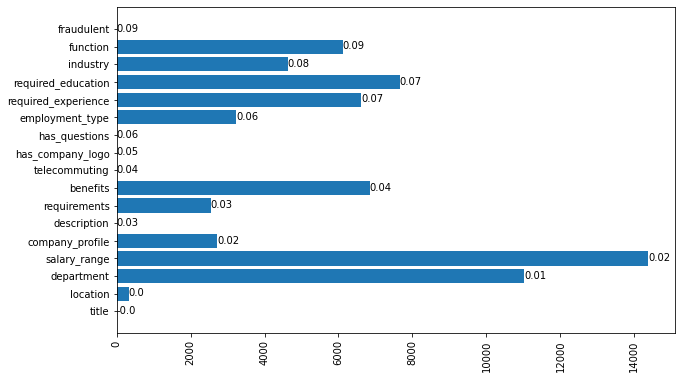

In [34]:
f1(job_data_real)

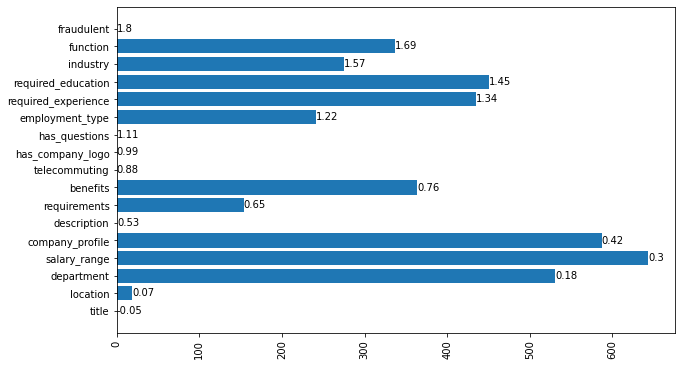

In [35]:
f1(job_data_fake)

In [36]:
import seaborn as sns

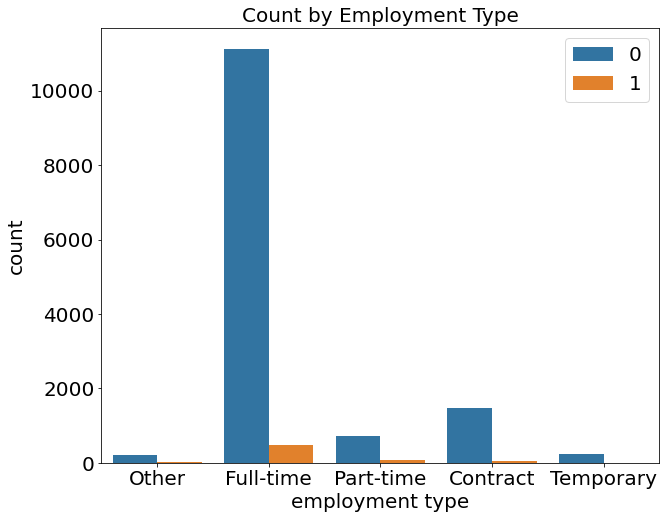

In [49]:
# categorical feature effect on the fraudulent classes
plt.figure(1,figsize=(10,8))
sns.countplot(hue=job_data.fraudulent,x=job_data.employment_type);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("employment type", fontsize=20)
plt.ylabel("count", fontsize=20)
plt.legend(fontsize=20)
plt.title('Count by Employment Type', fontsize=20);

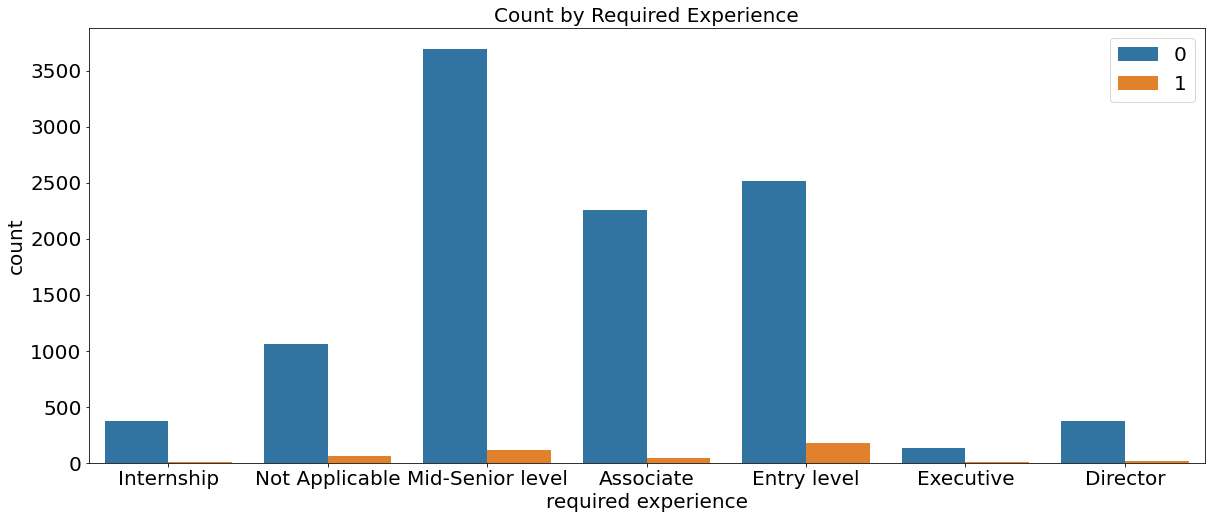

In [57]:
plt.figure(1,figsize=(20,8))
sns.countplot(hue=job_data.fraudulent,x=job_data.required_experience);
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("required experience", fontsize=20)
plt.ylabel("count", fontsize=20)
plt.legend(fontsize=20)
plt.title('Count by Required Experience', fontsize=20);

No handles with labels found to put in legend.


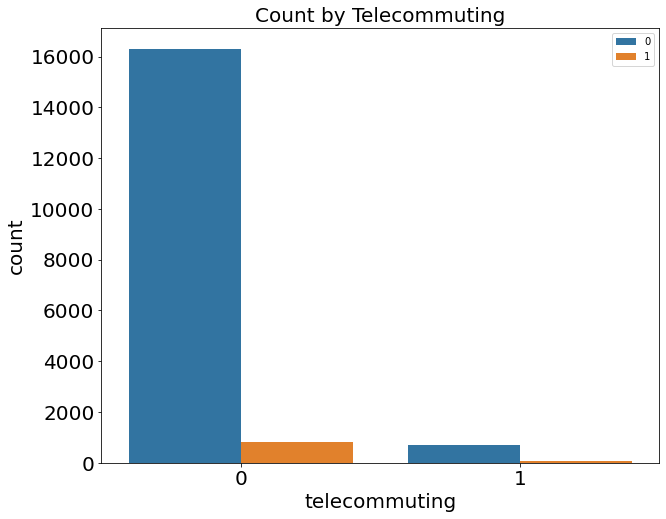

In [64]:
plt.figure(1,figsize=(10,8))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("telecommuting", fontsize=20)
plt.ylabel("count", fontsize=20)
plt.legend(fontsize=20)
plt.title('Count by Telecommuting', fontsize=20);
sns.countplot(hue=job_data.fraudulent,x=job_data.telecommuting)
plt.legend(loc='upper right')

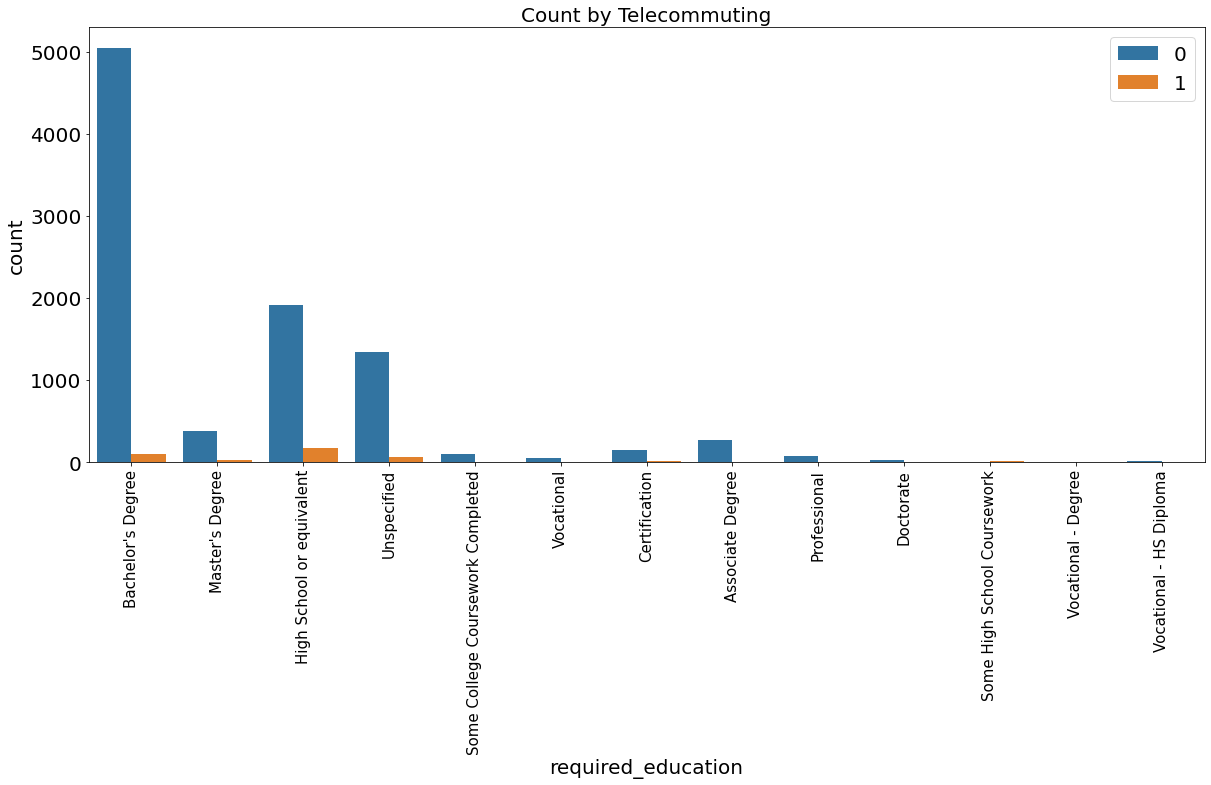

In [70]:
plt.figure(1,figsize=(20,8))
plt.xticks(fontsize=15)
plt.xticks(rotation='90')
plt.yticks(fontsize=20)
plt.xlabel("telecommuting", fontsize=20)
plt.ylabel("count", fontsize=20)
plt.title('Count by Telecommuting', fontsize=20);
sns.countplot(hue=job_data.fraudulent,x=job_data.required_education)
plt.legend(loc='upper right',fontsize=20)

# Model Dump

In [1]:
import pickle
import config
import numpy as np
import pandas as pd
import os
import yaml
import tensorflow as tf
import FeatureEngineering as FE
import ModelTraining as MT
from keras.models import Sequential,load_model
from keras.wrappers import scikit_learn
from keras import backend as K
from sklearn.metrics import confusion_matrix

/Users/JoeCheung/Desktop/423AnalyticsValueChain/Project/JobpostDetection


Using TensorFlow backend.


In [6]:
tf.compat.v1.enable_eager_execution()

In [4]:
data = pd.read_csv(config.DATA_CLEANED_PATH)

In [2]:
sav_path=config.MODEL_PATH+'model_file.pickle'
np.random.seed(423)
tf.random.set_seed(423)
os.environ['PYTHONHASHSEED']=str(423)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
# get params space from model_config.yml file
with open(os.path.join(config.PROJECT_HOME, 'model','src','model_config.yml'), 'r') as f: 
    params_training = yaml.load(f)

batch_size = params_training["model_production"]["batch_size"]
epochs = params_training["model_production"]["epochs"]
optimizer = params_training["model_production"]["optimizer"]

X_train, X_test, y_train, y_test = FE.train_test_split_stratified(data)   # train test split with stratified sampling
X_train_vec, X_test_vec = FE.FE_text_feature(X_train, X_test)   # extract text feature
X_train_SD, X_test_SD = FE.FE_standardize(X_train_vec, X_test_vec)   # standardization
X_train_OH, X_test_OH = FE.FE_onehot(X_train_SD, X_test_SD)   # one-hot coding
g = tf.Graph()
with g.as_default():
    tf.random.set_seed(423)
    model = scikit_learn.KerasClassifier(build_fn=MT.create_model, input_dim=X_train_OH.shape[1], verbose=0, optimizer=optimizer, batch_size=batch_size, epochs=epochs)
    model.fit(X_train_OH, y_train)
    y_pred = model.predict(X_test_OH)

    cm = confusion_matrix(y_test, y_pred)
    print("Size of input:", X_test_OH.shape)
    print("The confusion matrix on the test data is as follows:")
    print(cm)


In [ ]:
y = data['fraudulent'].copy()
X = data.drop(['fraudulent'], axis=1)

X = FE.FE_text_feature(X, sav_path=(config.MODEL_PATH+'vec_file.pickle'))   # extract text feature
X = FE.FE_standardize(X, sav_path=(config.MODEL_PATH+'SD_file.pickle'))   # standardization
X = FE.FE_onehot(X, sav_path=(config.MODEL_PATH+'OH_file.pickle'))   # one-hot coding

g = tf.Graph()
with g.as_default():
    tf.random.set_seed(423)
    model = scikit_learn.KerasClassifier(build_fn=MT.create_model, input_dim=X.shape[1], verbose=0, optimizer=optimizer, batch_size=batch_size, epochs=epochs)
    model.fit(X, y)
    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)
    print("Size of input:", X.shape)
    print("The confusion matrix on the training data is as follows:")
    print(cm)
    model.model.save_weights(sav_path)

In [16]:
# Create a new model instance
model2 = MT.create_model(1138)
# Load the previously saved weights
model2.load_weights("a.ckpt")

In [21]:
model2.predict(X_test_OH)

array([[0.01089558],
       [0.01089558],
       [0.01089558],
       ...,
       [0.01089557],
       [1.        ],
       [0.01089557]], dtype=float32)

In [38]:
with open (sav_path+'input_size.txt', 'w') as f:
    f.write(str(X_test_OH.shape[1]))

In [45]:
with open ('/Users/JoeCheung/Desktop/423AnalyticsValueChain/Project/JobpostDetection/model/model_saved/input_size.txt', 'r') as f:
    line = int(f.readline())

In [46]:
line

1138

In [50]:
# predict
# T   a b
# R   c d
# U
# e
def confusion_matrix(a,b,c,d):
    recall = d/(d+c)
    precision = d/(d+b)
    accuracy= (a+d)/(a+b+c+d)
    print('recall: ',recall)
    print('precision: ',precision)
    print('accuracy: ',accuracy)

In [51]:
confusion_matrix(5060,37,73,187)

recall:  0.7192307692307692
precision:  0.8348214285714286
accuracy:  0.9794661190965093


In [52]:
confusion_matrix(16988,0,38,827)

recall:  0.9560693641618497
precision:  1.0
accuracy:  0.997871506189436


# Model Predict

In [28]:
import config as config
import FeatureEngineeringPred as FEP
import pickle
import numpy as np
import pandas as pd

def predict_fake_post(input_data):
    """ Predict based on users input
    Args:
        input_data (`DataFrame`): Input data needed to be predicted
    Returns:
        result (`Array`): Prediction
    """	

    result = None
    required_columns=['telecommuting', 'has_company_logo', 'has_questions']
    for col in required_columns:
        if col not in input_data.columns:
            return 0
            
    #try:
    input_data_FE = input_data.copy()
    input_data_FE = FEP.FE_text_feature_pred(input_data_FE,vec_file=config.MODEL_PATH+'vec_file.pickle')
    input_data_FE = FEP.FE_standardize_pred(input_data_FE,SD_file=config.MODEL_PATH+'SD_file.pickle')
    input_data_FE = FEP.FE_onehot_pred(input_data_FE, OH_file=config.MODEL_PATH+'OH_file.pickle')
    model = pickle.load(open(config.MODEL_PATH+'model_file.pickle', 'rb'))
    result = model.predict(input_data_FE)
    #if result == 1: print(input_data_FE['text'])
    #except:
        #pass
    return result



In [29]:
input_data = pd.read_csv(config.DATA_CLEANED_PATH)

In [30]:
p = predict_fake_post(input_data)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [54]:
print(input_data[p==1]['text'][0:2])

572    senior engineering product manager aptitude st...
936    health environmental professional aptitude sta...
Name: text, dtype: object
